# IS 4487 Assignment 9: Customer Segmentation with Clustering

In this assignment, you will:
- Apply unsupervised learning to explore patterns in hotel booking behavior
- Use K-Means and Gaussian Mixture Models (GMM) for customer segmentation
- Evaluate model quality with metrics like Silhouette Score and Davies-Bouldin Index
- Connect clustering to actionable business insights

## Why This Matters

Businesses like hotels and travel platforms (e.g., Airbnb or Expedia) rely on customer segmentation to tailor promotions, pricing strategies, and service levels. Unlike supervised models, clustering helps uncover patterns when no labels exist—an ideal tool when entering new markets or analyzing unstructured customer behavior.

<a href="https://colab.research.google.com/github/vandanara/UofUtah_IS4487/blob/main/Assignments/assignment_09_clustering.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Dataset Description: Hotel Bookings

This dataset contains booking information for two types of hotels: a **city hotel** and a **resort hotel**. Each record corresponds to a single booking and includes various details about the reservation, customer demographics, booking source, and whether the booking was canceled.

**Source**: [GitHub - TidyTuesday: Hotel Bookings](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md)

### Key Use Cases
- Understand customer booking behavior
- Explore factors related to cancellations
- Segment guests based on booking characteristics
- Compare city vs. resort hotel performance

### Data Dictionary

| Variable | Type | Description |
|----------|------|-------------|
| `hotel` | character | Hotel type: City or Resort |
| `is_canceled` | integer | 1 = Canceled, 0 = Not Canceled |
| `lead_time` | integer | Days between booking and arrival |
| `arrival_date_year` | integer | Year of arrival |
| `arrival_date_month` | character | Month of arrival |
| `stays_in_weekend_nights` | integer | Nights stayed on weekends |
| `stays_in_week_nights` | integer | Nights stayed on weekdays |
| `adults` | integer | Number of adults |
| `children` | integer | Number of children |
| `babies` | integer | Number of babies |
| `meal` | character | Type of meal booked |
| `country` | character | Country code of origin |
| `market_segment` | character | Booking source (e.g., Direct, Online TA) |
| `distribution_channel` | character | Booking channel used |
| `is_repeated_guest` | integer | 1 = Repeated guest, 0 = New guest |
| `previous_cancellations` | integer | Past booking cancellations |
| `previous_bookings_not_canceled` | integer | Past bookings not canceled |
| `reserved_room_type` | character | Initially reserved room type |
| `assigned_room_type` | character | Room type assigned at check-in |
| `booking_changes` | integer | Number of booking modifications |
| `deposit_type` | character | Deposit type (No Deposit, Non-Refund, etc.) |
| `agent` | character | Agent ID who made the booking |
| `company` | character | Company ID (if booking through company) |
| `days_in_waiting_list` | integer | Days on the waiting list |
| `customer_type` | character | Booking type: Contract, Transient, etc. |
| `adr` | float | Average Daily Rate (price per night) |
| `required_car_parking_spaces` | integer | Requested parking spots |
| `total_of_special_requests` | integer | Number of special requests made |
| `reservation_status` | character | Final status (Canceled, No-Show, Check-Out) |
| `reservation_status_date` | date | Date of the last status update |

This dataset is ideal for classification, segmentation, and trend analysis exercises.

## 1. Setup and Load Data

Business framing:  

Before we can cluster or segment anything, we need clean, accessible data in a usable format.

- Import the necessary Python libraries
- Load the hotel bookings dataset [(Download Here)](https://github.com/rfordatascience/tidytuesday/blob/main/data/2020/2020-02-11/readme.md#get-the-data-here)
- Display the first few rows

### In Your Response:
1. What stands out in the initial preview? Any columns or rows that seem unusual?


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### ✍️ Your Response: 🔧
1. In my initial observation of the data, I found that "agent" and "company" columns have tons of missing data that needs to be removed. The columns "arrival_date_year", "arrival_date_month", "arrival_date_day_of_month", and "reservation_status_date" are all columns that will need improvements in order to develop patters on the data. The data overall suggest long lead times before bookings without many canceled reservations.

## 2. Select and Prepare Features

Business framing:  

A hotel might want to group guests based on how long they stay, how far in advance they book, or how likely they are to make special requests. You need to pick variables that represent meaningful guest behavior.

- Choose 3–5 numeric features related to customer behavior
- Drop missing values if needed
- Standardize using `StandardScaler`

### In Your Response:
1. What features did you select and why?
2. What kinds of patterns or segments do you expect to find?


In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select features related to customer behavior
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adr', 'total_of_special_requests']
df_clustering = df[features].copy()

# Drop rows with missing values in the selected features
df_clustering.dropna(inplace=True)

# Handle potential infinite values in adr
df_clustering['adr'] = df_clustering['adr'].replace([np.inf, -np.inf], np.nan)
df_clustering.dropna(inplace=True)


# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

display(df_scaled[:5])

array([[ 2.22705112, -0.92889042, -1.31023993, -2.0150382 , -0.72069411],
       [ 5.9233847 , -0.92889042, -1.31023993, -2.0150382 , -0.72069411],
       [-0.90781407, -0.92889042, -0.78620716, -0.53093528, -0.72069411],
       [-0.85166723, -0.92889042, -0.78620716, -0.53093528, -0.72069411],
       [-0.84230942, -0.92889042, -0.2621744 , -0.07581038,  0.54066585]])

### ✍️ Your Response: 🔧
1. The type of features that I selected was "lead_time" because it represents how far in advance that bookings were made which helps distinguish the type of travelers that plan ahead. There are other measures that show how long their stay was which helps reveal normal vs business travelers. We can also visualize the type of travelers that spend more money on personalized service

2. The types of patterns and segments I expected to find in the data was the last minue bookers and the length of their stay. The travelers that plan ahead are more likely to stay for longer trips. The budget travelers are more likely to have a low adr, while higher spenders are the inverse. One pattern I found interesting was the difference between "budget last-minute travelers" or "luxury planners with special requests."


## 3. Apply K-Means Clustering

Business framing:  

Let’s say you’re working with the hotel’s marketing manager. She wants to group guests into a few clear types to target email campaigns. K-Means is a fast, simple way to try this.

- Fit a `KMeans` model with your selected features
- Choose a value of `k` (e.g. 3, 4, or 5)
- Predict clusters and assign to each guest
- Visualize using a scatterplot of 2 features

Much of this assignment has already been covered in the lab. Please be sure to complete the lab before the assignment.

### In Your Response:
1. What `k` value did you choose, and how did you decide?
2. What types of customers seem to show up in the clusters?



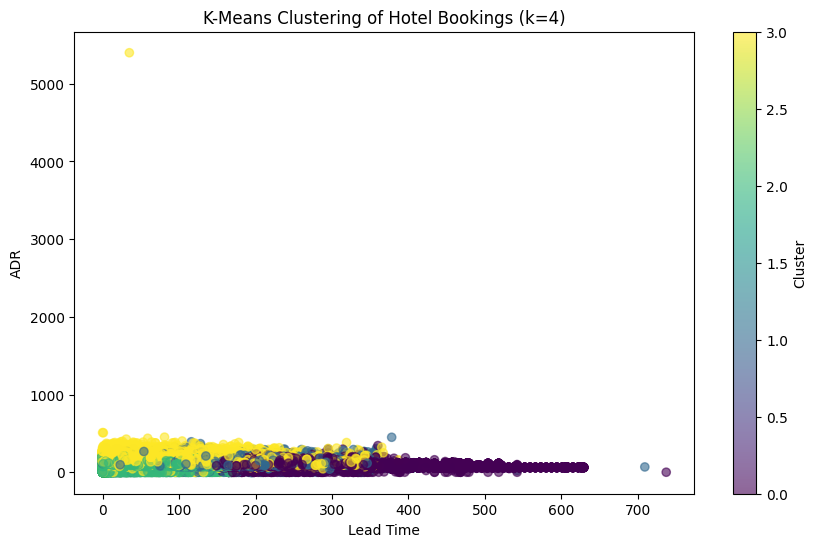

### ✍️ Your Response: 🔧
1. The "k" value that I chose is k=4 because it is the starting point for the KMeans transformation that does not require further analysis. Hsving 4 clusters is a good number to start these segments in the data.

2. The types of customers that I added to the scatterplot was "lead_time" and "adr" because they seem to have the biggest differentiation based on these two variables. I found these two clusters to give the most relevant information to answer the questions relating to the business problem.


## 4. Apply Gaussian Mixture Model (GMM)

Business framing:  

Not all guests fit neatly into one cluster. GMM lets us capture uncertainty — useful if customers behave similarly across groups.

- Fit a GMM with the same number of clusters you chose in Part 3
- Predict soft clusters (remember that soft clustering deals with probabilities, not labels)
- Visualize the GMM model so that you may compare it to the KMeans scatterplot

### In Your Response:
1. How did the GMM results compare to KMeans?
2. What business questions might GMM help answer better?


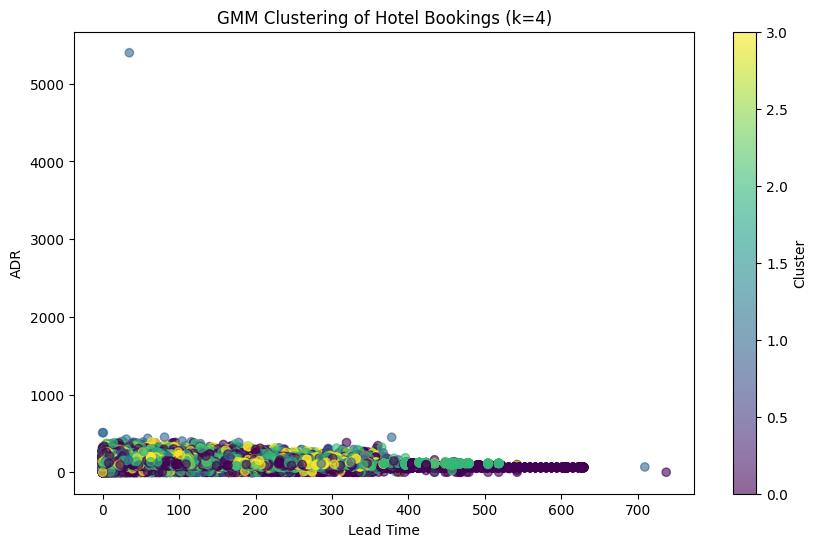

### ✍️ Your Response: 🔧
1. The GMM visuales with 4 clusters was more elliptical and oval-shaped compared to the KMeans scatterplot which was circular. The main difference between the two visualizations was that the GMM gave probability scores based on clusters while KMeans gave only single points of data.

2. Some business questions that GMM helps solve is the customer demographics that belong to multiple segments. This information is more relevant because gives us a detailed understanding of the types of customers and their behaviors.


## 5. Evaluate Your Models

Business framing:  

In business, models should be both useful and reliable. You’ll compare model quality using standard evaluation metrics.

- Calculate:
  - WCSS
  - Silhouette Score
  - Davies-Bouldin Index
- Compare both models

**Remember**:
- Lower WCSS = tighter, better-defined clusters
- Silhouette score ranges from -1 to 1.  Higher values = better clustering
- Lower Davies-Boulding Index = better clustering

### In Your Response:
1. Which model performed better on the metrics?
2. Would you recommend KMeans or GMM for a business analyst? Why?


In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate WCSS for KMeans
# WCSS (Within-Cluster Sum of Squares) is only directly applicable to KMeans
wcss = kmeans.inertia_

# Calculate Silhouette Score for both models
silhouette_kmeans = silhouette_score(df_scaled, df_clustering['kmeans_cluster'])
silhouette_gmm = silhouette_score(df_scaled, df_clustering['gmm_cluster'])

# Calculate Davies-Bouldin Index for both models
davies_bouldin_kmeans = davies_bouldin_score(df_scaled, df_clustering['kmeans_cluster'])
davies_bouldin_gmm = davies_bouldin_score(df_scaled, df_clustering['gmm_cluster'])

print(f"KMeans WCSS: {wcss}")
print(f"KMeans Silhouette Score: {silhouette_kmeans}")
print(f"KMeans Davies-Bouldin Index: {davies_bouldin_kmeans}")
print("-" * 30)
print(f"GMM Silhouette Score: {silhouette_gmm}")
print(f"GMM Davies-Bouldin Index: {davies_bouldin_gmm}")

KMeans WCSS: 346243.9698577152
KMeans Silhouette Score: 0.23285164553914312
KMeans Davies-Bouldin Index: 1.4098123263286104
------------------------------
GMM Silhouette Score: 0.12388534983967643
GMM Davies-Bouldin Index: 2.624348922677046


### ✍️ Your Response: 🔧
1. The model that performed better on the metrics would be the KMeans transformation because it had a higher Silhouette score of (0.233) compared to the GMM of (0.124). This means that the clusters were better at defining the data compared to the GMM transformations.

2. I would recommend the KMeans transformation as a business analyst because it gave better results when comparing the different types of evaluation metrics. The KMeans transformation had clear and better clusters that were seperated the different types of scores and indexes.


## 6. Business Interpretation

Business framing:  

What do these clusters mean in the real world? Could they represent solo travelers, families, or bargain shoppers?

- Review characteristics of each cluster (e.g. average `lead_time`, `special_requests`)
- Think from a marketing or hotel operations perspective

### In Your Response:
1. What do the segments represent in terms of guest behavior?
2. How could the hotel tailor services or promotions to each group?


,lead_time,stays_in_weekend_nights,stays_in_week_nights,adr,total_of_special_requests
kmeans_cluster,,,,,
0,272.176221,0.642105,2.200830,89.837767,0.195936
1,134.566089,2.388476,5.801003,101.491484,0.526366
2,45.504168,0.628329,1.755681,86.568845,0.226577
3,71.194670,0.903631,2.313683,140.829597,1.553604


### ✍️ Your Response: 🔧
1. The segments of clusters represent a ton of different factors when it comes to guest behavior. The firsr clusters help show which data types are most effective when it comes to a business analyst. Some transformations give data outputs that are easier to understand.

2. The hotel can tailor services or promotions to each group by grouping the different segments. Clustering especially helps in this scenario because it is using different segmented groups to organize the data. The clusters help give advice on what steps the hotel should make to help target these demographics.


## 7. Final Reflection

Business framing:  

Many teams ask for "segmentation" without knowing how it works. You now have hands-on experience with two clustering techniques and how to present the results.

### In Your Response:
1. What was most challenging about unsupervised learning?
2. When would you use clustering instead of supervised models?
3. How would you explain the value of clustering to a non-technical manager?
4. How does this relate to your customized learning outcome you created in canvas?


### ✍️ Your Response: 🔧
1. The most challenging part about unsupervised machine learning is that it determines the optimal number of clusters to organize the data. This model helps interpret the mening of each cluster groups based on the metrics they ask for. This also allows us to manage the performance level of each cluster and relate them to the overall business problem.

2. Instead of using a supervised machine learning model, I would use clustering when I have data without predefined labels or target variables. Clustering is significant when exploring important patterns directed to specific categories. This helps with customer segmentation and fully understanding the meaning between the different types of customers.

3. The way I would explain the value of clustering to a non-technical manager would be first by edxplaining the meaning of each cluster. Explaining the clusters will help get an understanding on why we use this process and how it benefits our strategies towards the customer demographics. I would then try and explain the outputs by showing the hidden patterns in the data and how they can be used to help solve the business problem.

4. I can relate this to the customized learning outcome I made in canvas by entering in the output I got from the data. This will allow me to describe the patterns I recognized with new ones the learning outcome came up with. The learning outcome I made in canvas will give me significant knowledge that will help me understand what the future steps I can continue with to solve the overall business problem.

## Submission Instructions

✅ **Before submitting:**
- Make sure all code cells are run and outputs are visible  
- All markdown questions are answered thoughtfully  
- Submit the assignment as an **HTML file** on Canvas


In [12]:
!jupyter nbconvert --to html "assignment_09_RylanceEvan.ipynb"

[NbConvertApp] Converting notebook assignment_09_RylanceEvan.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 483648 bytes to assignment_09_RylanceEvan.html
